# Facebook Ads Analysis — 2021 (Step by Step)




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

plt.rcParams['figure.figsize'] = (10, 5)
plt.rcParams['axes.grid'] = True

CSV_PATH = Path('facebook_ads_data.csv')  

def read_data(csv_path: Path) -> pd.DataFrame:
    if not csv_path.exists():
        raise FileNotFoundError(
            f"Не знайдено {csv_path}. Завантажте файл і покладіть його поруч із ноутбуком."
        )
    df = pd.read_csv(csv_path)
    df.columns = [c.strip().lower() for c in df.columns]

   
    rename_map = {}
    # ad_date
    if 'ad_date' not in df.columns:
        for alt in ['date', 'day', 'dt', 'ad date']:
            if alt in df.columns:
                rename_map[alt] = 'ad_date'
                break
    # campaign
    if 'campaign' not in df.columns:
        for alt in ['campaign_name', 'campaign id', 'campaign_name_id', 'name']:
            if alt in df.columns:
                rename_map[alt] = 'campaign'
                break
    # total_spend
    if 'total_spend' not in df.columns:
        for alt in ['spend', 'cost', 'amount_spent']:
            if alt in df.columns:
                rename_map[alt] = 'total_spend'
                break
    # total_value
    if 'total_value' not in df.columns:
        for alt in ['revenue', 'value', 'purchases_value', 'total_revenue']:
            if alt in df.columns:
                rename_map[alt] = 'total_value'
                break

    if rename_map:
        df = df.rename(columns=rename_map)

    required = {'ad_date', 'campaign', 'total_spend', 'total_value'}
    missing = required - set(df.columns)
    if missing:
        raise ValueError(
            f"Відсутні обов'язкові стовпці: {missing}. Доступні: {list(df.columns)}"
        )

    # ROMI = (total_value - total_spend)/total_spend
    df['romi'] = np.where(df['total_spend'] == 0, np.nan,
                          (df['total_value'] - df['total_spend']) / df['total_spend'])

    return df

try:
    df = read_data(CSV_PATH)
    display_cols = ['ad_date', 'campaign', 'total_spend', 'total_value', 'romi']
    display(df.head()[[c for c in display_cols if c in df.columns]])
except Exception as e:
    print(e)
    df = None


,ad_date,campaign,total_spend,total_value,romi
0,2022-11-05,Expansion,0.00,0.00,NaN
1,2022-11-01,Expansion,0.00,0.00,NaN
2,2022-10-31,Expansion,227.45,191.87,-0.156430
3,2022-10-30,Expansion,335.91,472.61,0.406954
4,2022-10-29,Expansion,714.03,680.34,-0.047183


In [2]:
# === Перевірка і обробка дублікатів ===

# 1. Повні дублікати (усі колонки збігаються)
dup_count_full = df.duplicated().sum()
print(f"Повних дублікатів у таблиці: {dup_count_full}")

if dup_count_full > 0:
    df = df.drop_duplicates()
    print(f"Після видалення повних дублікатів: {df.shape[0]} рядків")

# 2. Дублікати по ключу (ad_date + campaign)
dup_count_key = df.duplicated(subset=['ad_date','campaign']).sum()
print(f"Дублікатів по (ad_date, campaign): {dup_count_key}")

if dup_count_key > 0:
    # Агрегуємо дублікати: сумуємо total_spend і total_value
    df = (df.groupby(['ad_date','campaign'], as_index=False)
            .agg(total_spend=('total_spend','sum'),
                 total_value=('total_value','sum')))
    df['romi'] = np.where(df['total_spend']==0, np.nan,
                          (df['total_value'] - df['total_spend'])/df['total_spend'])
    print(f"Після агрегування: {df.shape[0]} рядків")

df.head()


Повних дублікатів у таблиці: 0
Дублікатів по (ad_date, campaign): 0


,ad_date,campaign,total_spend,total_impressions,total_clicks,total_value,cpc,cpm,ctr,romi
0,2022-11-05,Expansion,0.00,0,0,0.00,NaN,NaN,NaN,NaN
1,2022-11-01,Expansion,0.00,0,0,0.00,NaN,NaN,NaN,NaN
2,2022-10-31,Expansion,227.45,6054,58,191.87,3.92,37.57,0.009580,-0.156430
3,2022-10-30,Expansion,335.91,27562,69,472.61,4.87,12.19,0.002503,0.406954
4,2022-10-29,Expansion,714.03,33358,115,680.34,6.21,21.41,0.003447,-0.047183


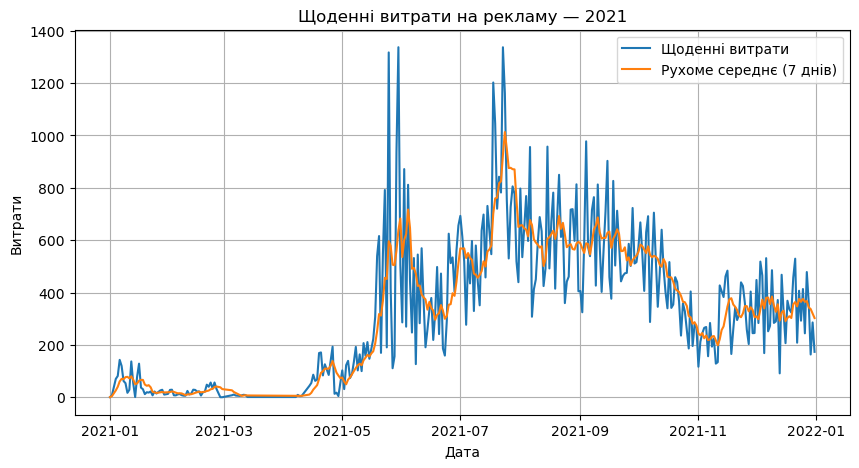

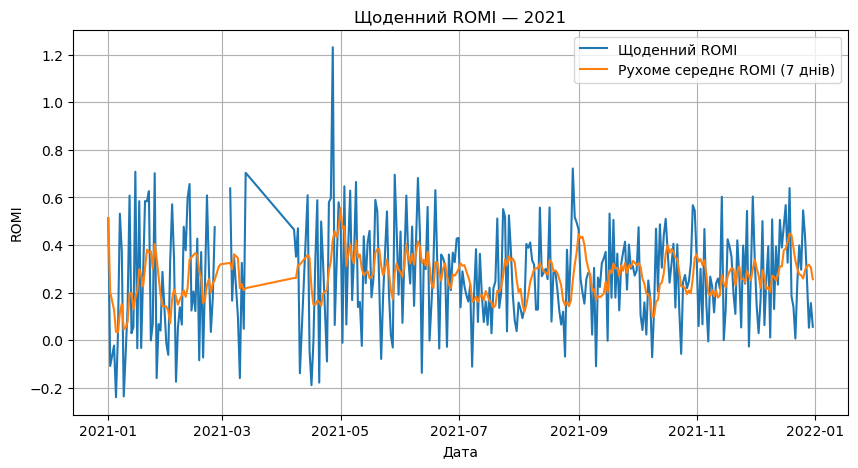

In [3]:
# === 1. Групування по днях (2021) і графіки витрат та ROMI + rolling ===
if df is not None:
    mask_2021 = (df['ad_date'] >= '2021-01-01') & (df['ad_date'] <= '2021-12-31')
    by_day = (df.loc[mask_2021]
                .groupby('ad_date', as_index=False)
                .agg(total_spend_daily=('total_spend', 'sum'),
                     total_value_daily=('total_value', 'sum')))
    by_day['romi_daily'] = np.where(by_day['total_spend_daily'] == 0, np.nan,
                                    (by_day['total_value_daily'] - by_day['total_spend_daily']) / by_day['total_spend_daily'])

    # Для rolling треба мати тип datetime
    by_day_dt = by_day.copy()
    by_day_dt['ad_date'] = pd.to_datetime(by_day_dt['ad_date'])
    by_day_dt = by_day_dt.sort_values('ad_date')

    # 7-денне рухоме середнє
    by_day_dt['spend_ma7'] = by_day_dt['total_spend_daily'].rolling(window=7, min_periods=1).mean()
    by_day_dt['romi_ma7'] = by_day_dt['romi_daily'].rolling(window=7, min_periods=1).mean()

    # Графік: щоденні витрати + MA7
    plt.figure()
    plt.plot(by_day_dt['ad_date'], by_day_dt['total_spend_daily'], label='Щоденні витрати')
    plt.plot(by_day_dt['ad_date'], by_day_dt['spend_ma7'], label='Рухоме середнє (7 днів)')
    plt.title('Щоденні витрати на рекламу — 2021')
    plt.xlabel('Дата')
    plt.ylabel('Витрати')
    plt.legend()
    plt.show()

    # Графік: щоденний ROMI + MA7
    plt.figure()
    plt.plot(by_day_dt['ad_date'], by_day_dt['romi_daily'], label='Щоденний ROMI')
    plt.plot(by_day_dt['ad_date'], by_day_dt['romi_ma7'], label='Рухоме середнє ROMI (7 днів)')
    plt.title('Щоденний ROMI — 2021')
    plt.xlabel('Дата')
    plt.ylabel('ROMI')
    plt.legend()
    plt.show()

    by_day_dt.head()



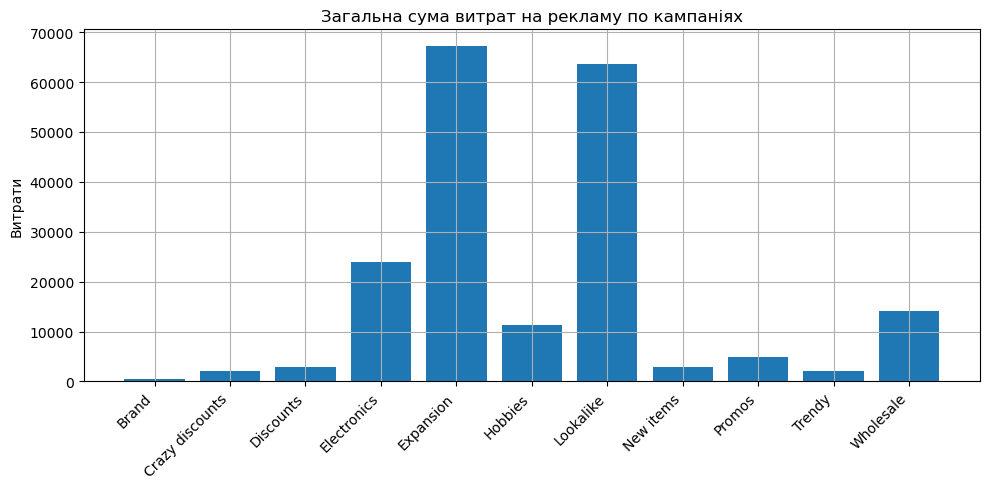

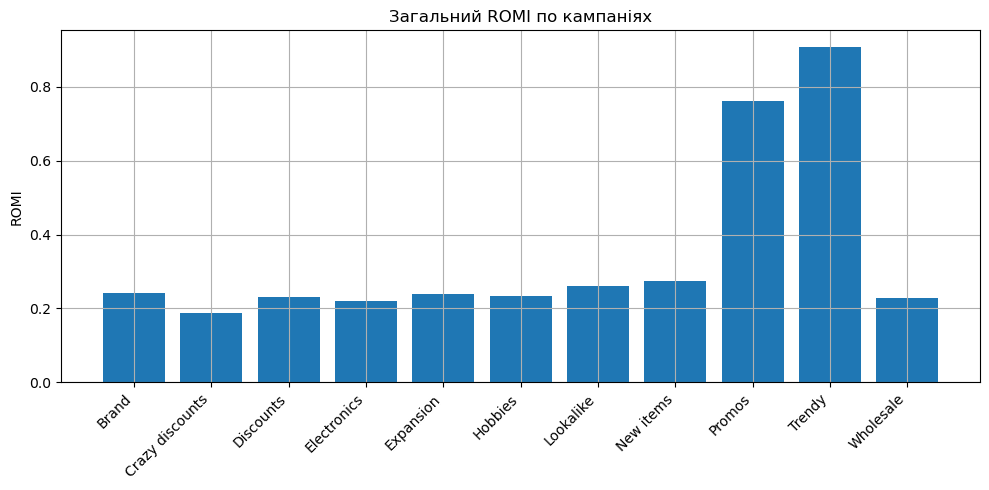

In [4]:
# === 2. Групування за кампаніями + графіки загальних витрат і загального ROMI ===
if df is not None:
    by_campaign = (df.groupby('campaign', as_index=False)
                     .agg(total_spend=('total_spend', 'sum'),
                          total_value=('total_value', 'sum')))
    by_campaign['romi'] = np.where(by_campaign['total_spend'] == 0, np.nan,
                                   (by_campaign['total_value'] - by_campaign['total_spend']) / by_campaign['total_spend'])

    # Стовпчикова діаграма витрат по кампаніях
    plt.figure()
    x = np.arange(len(by_campaign))
    plt.bar(x, by_campaign['total_spend'])
    plt.xticks(x, by_campaign['campaign'], rotation=45, ha='right')
    plt.title('Загальна сума витрат на рекламу по кампаніях')
    plt.ylabel('Витрати')
    plt.tight_layout()
    plt.show()

    # Стовпчикова діаграма ROMI по кампаніях
    plt.figure()
    plt.bar(x, by_campaign['romi'])
    plt.xticks(x, by_campaign['campaign'], rotation=45, ha='right')
    plt.title('Загальний ROMI по кампаніях')
    plt.ylabel('ROMI')
    plt.tight_layout()
    plt.show()

    by_campaign.head()



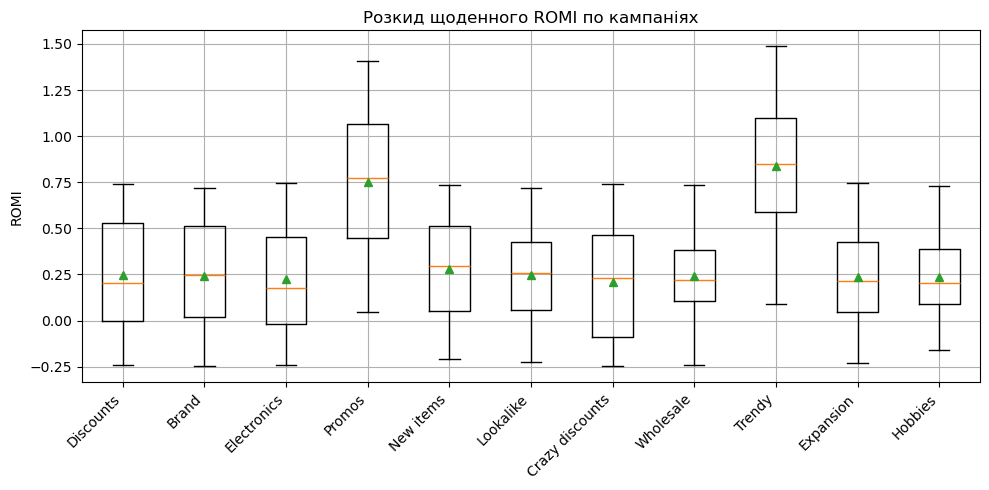

In [5]:
# === 3. Box plot розкиду щоденного ROMI по кампаніях ===
if df is not None:
    # Спочатку обчислимо щоденний ROMI у розрізі кампаній
    daily_campaign = (df.groupby(['ad_date', 'campaign'], as_index=False)
                        .agg(total_spend=('total_spend', 'sum'),
                             total_value=('total_value', 'sum')))
    daily_campaign['romi'] = np.where(daily_campaign['total_spend'] == 0, np.nan,
                                      (daily_campaign['total_value'] - daily_campaign['total_spend'])/daily_campaign['total_spend'])

    # Побудова boxplot: одна коробка на кампанію
    # Підготуємо дані як список масивів
    campaigns = daily_campaign['campaign'].unique()
    data_for_box = [daily_campaign.loc[daily_campaign['campaign'] == c, 'romi'].dropna().values for c in campaigns]
plt.figure()
plt.boxplot(data_for_box, tick_labels=campaigns, vert=True, showmeans=True)
plt.xticks(rotation=45, ha='right')
plt.title('Розкид щоденного ROMI по кампаніях')
plt.ylabel('ROMI')
plt.tight_layout()
plt.show()


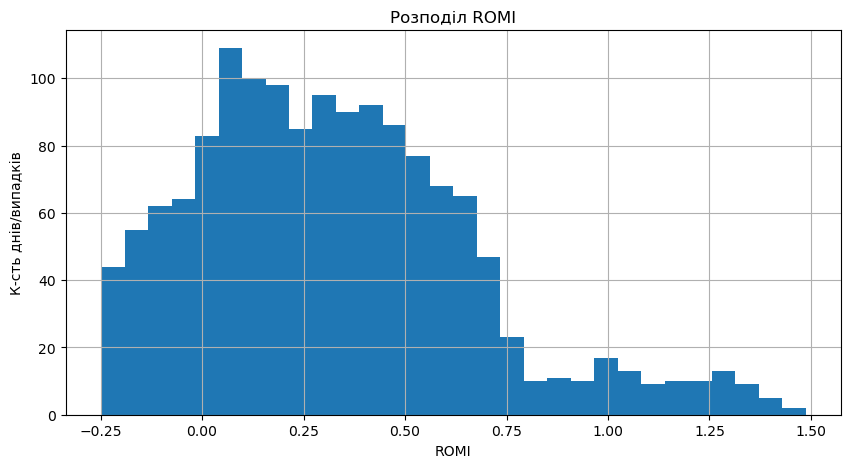

In [6]:
# === 4. Гістограма ROMI по всій таблиці ===
if df is not None:
    plt.figure()
    romi_clean = df['romi'].dropna()
    plt.hist(romi_clean, bins=30)
    plt.title('Розподіл ROMI')
    plt.xlabel('ROMI')
    plt.ylabel('К-сть днів/випадків')
    plt.show()



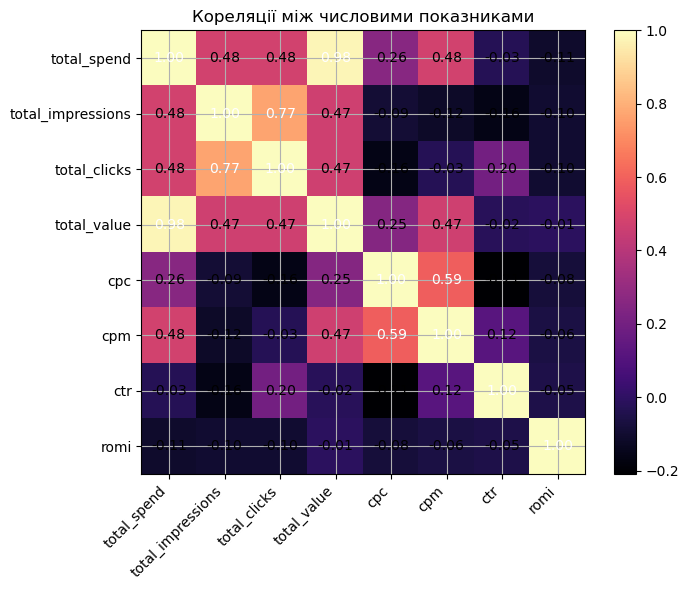

Найвища кореляція: total_spend <-> total_value = 0.98
Найнижча кореляція: cpc <-> ctr = -0.21

Кореляції з total_value (спадання):
total_spend          0.98
total_clicks         0.47
total_impressions    0.47
cpm                  0.47
cpc                  0.25
romi                -0.01
ctr                 -0.02


In [7]:
# === 5. Теплова карта кореляцій між ВСІМА числовими показниками  ===
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Вибір числових стовпців
numeric_df = df.select_dtypes(include=[np.number]).copy()
if numeric_df.shape[1] < 2:
    raise RuntimeError(f"Знайдено лише {numeric_df.shape[1]} числових колонок. Потрібно ≥2 для кореляцій.")

# 2. Обчислення кореляцій
corr = numeric_df.corr(numeric_only=True)
corr_disp = corr.round(2)

# 3. Побудова теплової карти
plt.figure(figsize=(8,6))
im = plt.imshow(corr_disp.values, interpolation='nearest', cmap='magma')
plt.title('Кореляції між числовими показниками')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(ticks=np.arange(len(corr_disp.columns)), labels=corr_disp.columns, rotation=45, ha='right')
plt.yticks(ticks=np.arange(len(corr_disp.index)), labels=corr_disp.index)

for i in range(corr_disp.shape[0]):
    for j in range(corr_disp.shape[1]):
        val = corr_disp.values[i, j]
        color = 'white' if abs(val) > 0.5 else 'black'
        plt.text(j, i, f"{val:.2f}", ha='center', va='center', color=color)

plt.tight_layout()
plt.show()

# 4. Найвища / найнижча кореляції
mask_upper = np.triu(np.ones_like(corr, dtype=bool), k=1)
pairs = (
    pd.DataFrame(corr.where(mask_upper))
      .stack()
      .reset_index()
      .rename(columns={'level_0': 'var1', 'level_1': 'var2', 0: 'corr'})
)

if pairs.empty:
    print("Не знайдено валідних пар для порівняння кореляцій.")
else:
    best = pairs.loc[pairs['corr'].idxmax()]
    worst = pairs.loc[pairs['corr'].idxmin()]
    print(f"Найвища кореляція: {best['var1']} <-> {best['var2']} = {best['corr']:.2f}")
    print(f"Найнижча кореляція: {worst['var1']} <-> {worst['var2']} = {worst['corr']:.2f}")

# 5. Кореляції з total_value
if 'total_value' in corr.columns:
    tv_corr = corr['total_value'].drop(labels=['total_value'], errors='ignore').sort_values(ascending=False).round(2)
    print("\nКореляції з total_value (спадання):")
    print(tv_corr.to_string())
else:
    print("\nКолонки 'total_value' немає серед числових для розрахунку кореляцій.")


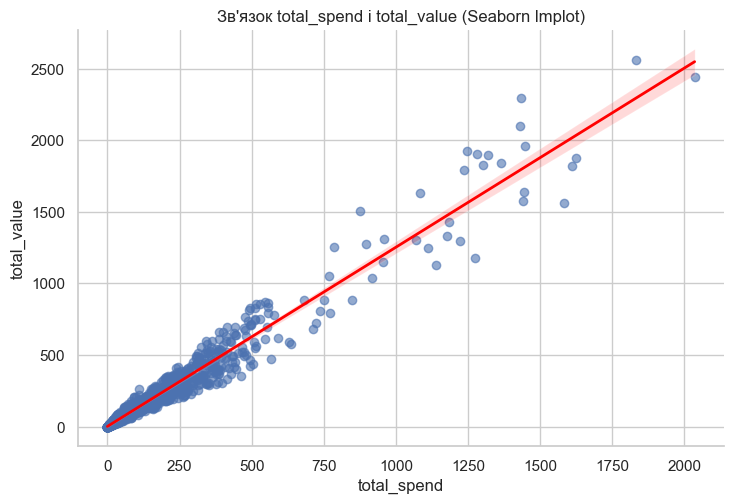

In [8]:
# === 6. Точкова діаграма з лінійною регресією (lmplot) ===

import seaborn as sns
sns.set(style="whitegrid")

# Побудова lmplot
sns.lmplot(
    data=df,
    x="total_spend",
    y="total_value",
    height=5,       
    aspect=1.5,     
    scatter_kws={"alpha":0.6},  
    line_kws={"color":"red", "lw":2}  
)

plt.title("Зв'язок total_spend і total_value (Seaborn lmplot)", fontsize=12)
plt.xlabel("total_spend")
plt.ylabel("total_value")
plt.show()



# 📊 Аналіз рекламних кампаній Facebook — 2021

### Автор:
**Oleh Ustimov**

### Мета:
Дослідити ефективність рекламних кампаній Facebook за 2021 рік, використовуючи інструменти **Python** та **Pandas**.  
Завдання включає обробку даних, побудову ключових візуалізацій та аналіз взаємозв’язків між метриками.

---

### 🔍 Кроки аналізу:

1. **Завантаження даних** з файлу `facebook_ads_data.csv` у DataFrame Pandas.  
2. **Групування по днях (2021):**  
   - побудова графіка щоденних витрат;  
   - побудова графіка щоденного ROMI;  
   - розрахунок рухомого середнього.  
3. **Групування за кампаніями:**  
   - загальні витрати по кожній кампанії;  
   - загальний ROMI по кампаніях.  
4. **Box Plot:** аналіз розкиду щоденного ROMI по кампаніях.  
5. **Гістограма:** розподіл значень ROMI по всій таблиці.  
6. **Теплова карта кореляцій:**  
   - визначення найвищої та найнижчої кореляцій;  
   - виявлення, з чим найбільше корелює `total_value`.  
7. **Точкова діаграма (lmplot):**  
   - візуалізація зв’язку між `total_spend` та `total_value` з лінійною регресією.

---

### 📅 Період аналізу:
**1 січня 2021 — 31 грудня 2021**

### 🧰 Використані бібліотеки:
`pandas`, `numpy`, `matplotlib`, `seaborn`

